# Pothole & Plain road Classification Using Transfer Learning & CNN

This project shows how to implement a transfer learning and CNN based solution to solve image classification problems. Data from the [Pothole and Plain Road Images](https://www.kaggle.com/virenbr11/pothole-and-plain-rode-images) Kaggle dataset is used in this project. 

The goal of this project is to build a model that identifies if the images has pothole or is a plain road without potholes. Accordingly, it is a binary classification problem. The training data contains 420 images.

**Dataset**
* Inputs: Images of potholes and plain roads.
* Outputs: Classification label (Pothole or Plain road).
* You can download the original dataset from this [link](https://www.kaggle.com/virenbr11/pothole-and-plain-rode-images).

**Error metric**
* Percentage of correctly labeled images (accuracy). 

**Evaluation protocol**
* Fully-connected layers : Hold-out validation. 
* Global average pooling : Hold-out validation.
* Support vector machines: K-fold cross-validation.

**Performance goals**
* Accuracy > 0.90

**Solution using *3 MODELS***
1. [Fully-connected layers](#Classifier1:-Fully-Connected-Layer-Model)
1. [Global average pooling](#Classifier2:-Global-Average-Pooling-Model)
1. [Linear support vector machines](#Classifier3:-Linear-Support-Vector-Machine-Model)

## Imports

In [8]:
import os
import shutil
from keras.preprocessing.image import ImageDataGenerator

In [59]:
import random
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image

## Setting directory paths

In [60]:
!unzip /content/drive/MyDrive/Data.zip

Archive:  /content/drive/MyDrive/Data.zip
replace Data/train/pothole/93.957390ad-96df-4798-b287-1758e3936ac5-pothole_012719_ES10.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [6]:
base_dir = r"/content/Data"

In [10]:
train_dir = os.path.join(base_dir,'train')
test_dir = os.path.join(base_dir,'test')
validation_dir = os.path.join(base_dir,'validation')

In [11]:
train_plain_dir = os.path.join(train_dir,'plain')
train_pothole_dir = os.path.join(train_dir,'pothole')

In [12]:
test_plain_dir = os.path.join(test_dir,'plain')
test_pothole_dir = os.path.join(test_dir,'pothole')

In [13]:
validation_plain_dir = os.path.join(validation_dir,'plain')
validation_pothole_dir = os.path.join(validation_dir,'pothole')

In [14]:
# Sanity checks
print('total training plain images :', len(os.listdir(train_plain_dir)))
print('total training pothole images : ',len(os.listdir(train_pothole_dir)))
print('total validation plain images :', len(os.listdir(validation_plain_dir)))
print('total validation pothole images :', len(os.listdir(validation_pothole_dir)))
print('total test plain images :', len(os.listdir(test_plain_dir)))
print('total test pothole images :', len(os.listdir(test_pothole_dir)))

total training plain images : 210
total training pothole images :  211
total validation plain images : 70
total validation pothole images : 70
total test plain images : 70
total test pothole images : 70


## Re-scaling images to 224 X 224 to match VGG16 input size

In [15]:
train_size, validation_size, test_size = 420,140,140
img_width, img_height = 224, 224

So now we have a <b><u>balanced dataset</u></b> with:
* 420 training images    (210 pothole + 210 plain road).
* 140 validation images  (70 pothole + 70 plain road).
* 140 test images        (70 pothole + 70 plain road).

67.Ice_road_saimaa.JPG


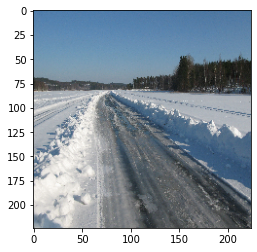

72._100559457_hi032479987.jpg


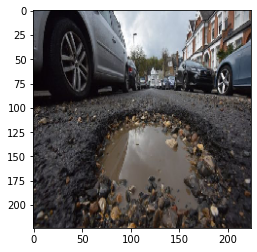

7._88068994_thinkstockphotos-493881770.jpg


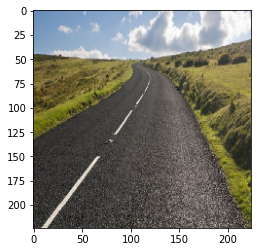

81.sen-l-potholes-2-e1571161784457.jpg


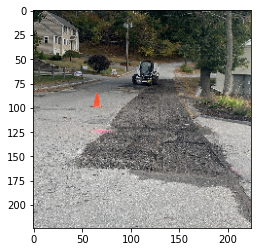

In [16]:
def show_pictures(path):
    random_img = random.choice(os.listdir(path))
    img_path = os.path.join(path, random_img)
    print(random_img)
    img = image.load_img(img_path, target_size=(img_width, img_height))
    img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
    img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application
    plt.imshow(img_tensor)
    plt.show()
    
for i in range(0,2):
    show_pictures(train_plain_dir)
    show_pictures(train_pothole_dir)

## Obtaining the pre-trained weights from VGG16 for the Convolutional Base

In this project, we want to use a solution based on pre-trained models. We will use models that are composed of two parts:
* Convolutional base.
* Classifier.

Our approach will use the convolutional base to extract features, using them to train a classifier to classify the input image as pothole or plain road. Therefore, the features extracted from the convolutional base will be the same for all classifiers studied in this example.

In [19]:
import keras
from keras.applications.vgg16 import VGG16 

# Input Shape: (224 X 224 X 3) where 3 is the number of input color channels, RGB
conv_base = VGG16(weights='imagenet', 
                  include_top=False,
                  input_shape=(img_width, img_height, 3))

58900480/58889256 [==============================] - 1s 0us/step


Line by line, what we are doing in VGG16 is:
* **weights** initializes model's weights. Here we are saying that we want to use the same weights as [ImageNet](http://www.image-net.org/). This is smart because we know that our dataset is similar to the ImageNet dataset (i.e. it has dogs and cats).
* **include_top** as false means that we want to train our own classifier on top of the convolutional base. The original VGG16 classifies images according to a set of 1 000 possible classes. Here we are just classifying our images. 
* **input_shape** defines the shape of the image tensors that will feed the network. We used the default input size of VGG16 (224x224).

We can now check the architecture of the convolutional base that we instantiated.

In [20]:
# Check architecture
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Loading Dataset

Now that we have the convolutional base, we need to pass our images through it for feature extraction.
We use *flow_from_directory* method, the labels are inferred from the directory structure.

In [21]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 512))  # Must be equal to the output of the convolutional base
    labels = np.zeros(shape=(sample_count))
    # Preprocess data
    generator = datagen.flow_from_directory(directory,
                                            target_size=(img_width,img_height),
                                            batch_size = batch_size,
                                            class_mode='binary')
    # Pass data through convolutional base
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels
    
train_features, train_labels = extract_features(train_dir, train_size)  # Agree with our small dataset size
validation_features, validation_labels = extract_features(validation_dir, validation_size)
test_features, test_labels = extract_features(test_dir, test_size)

Found 420 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Found 140 images belonging to 2 classes.
Found 140 images belonging to 2 classes.


In [ ]:
# Debug
print(train_features)
print(train_labels)

Each sample has a wide range of features and labels are 0 or 1.

Now that we have the features, we can use the three classifiers that we suggest in this project. Accordingly, on top of our convolutional base, we will add a classifier and then our model is ready to make predictions.

In [23]:
train_features.shape

(420, 7, 7, 512)

## Classifier1: Fully Connected Layer Model
### Model Definition

We build a classifier based on fully-connected layers. This classifier will use the features extracted from the convolutional base.

In [28]:
# Define model
from keras import models
from keras import layers
from keras import optimizers
import tensorflow as tf


epochs = 100

model = models.Sequential()
model.add(layers.Flatten(input_shape=(7,7,512)))
model.add(layers.Dense(256, activation='relu', input_dim=(7*7*512)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               6422784   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 6,423,041
Trainable params: 6,423,041
Non-trainable params: 0
_________________________________________________________________


In [29]:
# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['acc'])

In [30]:
# Train model
history = model.fit(train_features, train_labels,
                    epochs=epochs,
                    batch_size=batch_size, 
                    validation_data=(validation_features, validation_labels))

Epoch 1/100
14/14 [==============================] - 1s 64ms/step - loss: 0.7956 - acc: 0.7929 - val_loss: 0.3391 - val_acc: 0.9286
Epoch 2/100
14/14 [==============================] - 1s 51ms/step - loss: 0.1706 - acc: 0.9619 - val_loss: 0.2033 - val_acc: 0.9500
Epoch 3/100
14/14 [==============================] - 1s 53ms/step - loss: 0.0937 - acc: 0.9738 - val_loss: 0.2178 - val_acc: 0.9643
Epoch 4/100
14/14 [==============================] - 1s 49ms/step - loss: 0.0642 - acc: 0.9762 - val_loss: 0.1594 - val_acc: 0.9571
Epoch 5/100
14/14 [==============================] - 1s 51ms/step - loss: 0.0324 - acc: 0.9857 - val_loss: 0.2056 - val_acc: 0.9500
Epoch 6/100
14/14 [==============================] - 1s 51ms/step - loss: 0.0361 - acc: 0.9929 - val_loss: 0.1939 - val_acc: 0.9429
Epoch 7/100
14/14 [==============================] - 1s 49ms/step - loss: 0.0396 - acc: 0.9857 - val_loss: 0.1979 - val_acc: 0.9429
Epoch 8/100
14/14 [==============================] - 1s 50ms/step - loss: 0.

In [31]:
# Save model
model.save('pothole_fcl.h5')

In [ ]:
# from tensorflow import keras
# # Load model
# model = keras.models.load_model('pothole_fcl.h5')

### Classifier1: Fully Connected Layer Model Evaluation

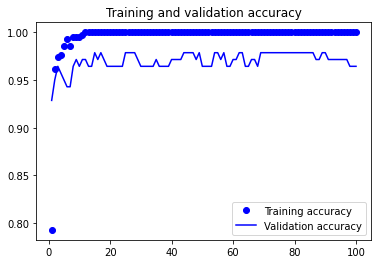

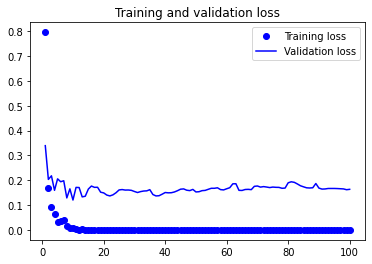

In [32]:
# Plot results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Classifier1: Fully Connected Layer Model in Action

In [33]:
# Define function to visualize predictions
def visualize_predictions(classifier, n_cases):
    for i in range(0,n_cases):
        path = random.choice([test_plain_dir, test_pothole_dir])

        # Get picture
        random_img = random.choice(os.listdir(path))
        img_path = os.path.join(path, random_img)
        img = image.load_img(img_path, target_size=(img_width, img_height))
        img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
        img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application

        # Extract features
        features = conv_base.predict(img_tensor.reshape(1,img_width, img_height, 3))

        # Make prediction
        try:
            prediction = classifier.predict(features)
        except:
            prediction = classifier.predict(features.reshape(1, 7*7*512))

        # Show picture
        plt.imshow(img_tensor)
        plt.show()

        # Write prediction
        if prediction < 0.5:
            print('Plain')
        else:
            print('Pothole')

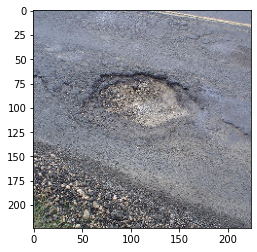

Pothole


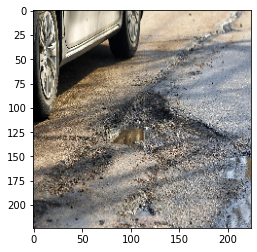

Pothole


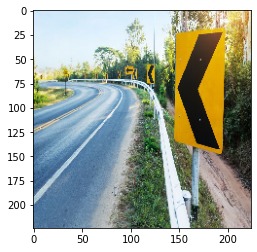

Plain


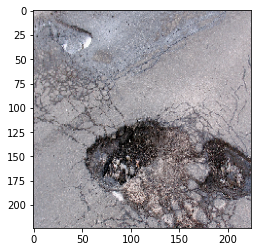

Pothole


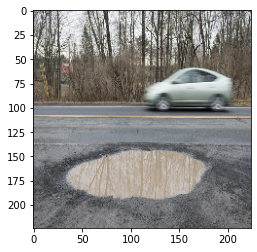

Pothole


In [34]:
# Visualize predictions
visualize_predictions(model, 5)

### Classifier1: Fully Connected Layer Model Performance Metrics

In [36]:
# Define function to visualize predictions
import warnings
warnings.warn("ignore")

def test_output(classifier):
    result = []
    for f in test_features:
      try:
          prediction = classifier.predict(f)
      except:
          prediction = classifier.predict(f.reshape(1, 7, 7, 512))
      if(prediction < 0.5):
        result.append(0)
      else:
        result.append(1)
        
    return result
o = test_output(model)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: ignore
  This is separate from the ipykernel package so we can avoid doing imports until


Confusion Matrix: 
[[68  2]
 [ 2 68]]
Accuracy:  0.9714285714285714
Specificity:  0.9714285714285714
Precision/Positive Predictive Value:  0.9714285714285714
Negative Predictive Value:  0.9714285714285714
Recall/Sensitivity:  0.9714285714285714
False Positive Rate:  0.5
False Negative Rate:  0.02857142857142857
Positive Likelihood Ratio:  1.9428571428571428
Negative Likelihod Ratio:  0.029411764705882353
Diagnostic Odds Ratio:  66.05714285714286
False Omission Rate:  0.02857142857142857
F1 Score:  0.9714285714285714
Area under ROC curve:  0.9714285714285715


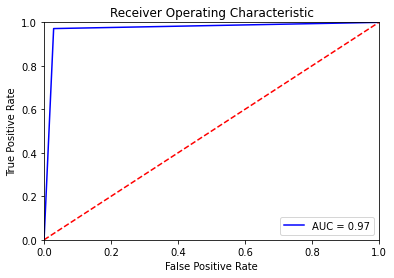

In [37]:
from sklearn.metrics import *
matrix = confusion_matrix(test_labels, o)
print("Confusion Matrix: ")
print(matrix)
[[tn, fp], [fn, tp]] = matrix

acc_score = accuracy_score(test_labels, o)
precision = precision_score(test_labels, o)
recall = tpr = recall_score(test_labels, o)
f1 = f1_score(test_labels, o)
roc_score = roc_auc_score(test_labels, o)
spc = tnr = tn/(tn + fp)
fpr = fp/(fp + fn)
fnr = fn/(fn+tp)
plr = tpr/fpr
nlr = fnr/tnr
dor = plr/nlr
npv = tn/(fn+tn)
fr = fn/(fn+tn)

print("Accuracy: ", acc_score)
print("Specificity: ", spc)
print("Precision/Positive Predictive Value: ", precision)
print("Negative Predictive Value: ", npv)
print("Recall/Sensitivity: ", recall)
print("False Positive Rate: ", fpr)
print("False Negative Rate: ", fnr)
print("Positive Likelihood Ratio: ", plr)
print("Negative Likelihod Ratio: ", nlr)
print("Diagnostic Odds Ratio: ", dor)
print("False Omission Rate: ", fr)
print("F1 Score: ", f1)
print("Area under ROC curve: ", roc_score)


fpr, tpr, threshold = roc_curve(test_labels, o)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Classifier2: Global Average Pooling Model
### Model Definition

The difference between this case and the previous one is that, instead of adding a stack of fully-connected layers, we will add a global average pooling layer and fed its output into a sigmoid activated layer.

We are using the sigmoid activation because in Keras, to perform binary classification, you should use sigmoid activation and binary_crossentropy as the loss.

In [38]:
# Define model
from keras import models
from keras import layers
from keras import optimizers

epochs = 100

model = models.Sequential()
model.add(layers.GlobalAveragePooling2D(input_shape=(7,7,512)))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_4 (Dense)             (None, 1)                 513       
                                                                 
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________


In [39]:
# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['acc'])

In [40]:
# Train model
history = model.fit(train_features, train_labels,
                    epochs=epochs,
                    batch_size=batch_size, 
                    validation_data=(validation_features, validation_labels))

Epoch 1/100
14/14 [==============================] - 1s 26ms/step - loss: 0.7831 - acc: 0.4905 - val_loss: 0.7312 - val_acc: 0.4214
Epoch 2/100
14/14 [==============================] - 0s 8ms/step - loss: 0.7082 - acc: 0.4643 - val_loss: 0.6978 - val_acc: 0.5357
Epoch 3/100
14/14 [==============================] - 0s 9ms/step - loss: 0.6734 - acc: 0.6286 - val_loss: 0.6613 - val_acc: 0.6357
Epoch 4/100
14/14 [==============================] - 0s 8ms/step - loss: 0.6354 - acc: 0.7929 - val_loss: 0.6284 - val_acc: 0.7786
Epoch 5/100
14/14 [==============================] - 0s 8ms/step - loss: 0.6041 - acc: 0.8095 - val_loss: 0.6004 - val_acc: 0.8143
Epoch 6/100
14/14 [==============================] - 0s 9ms/step - loss: 0.5743 - acc: 0.8786 - val_loss: 0.5778 - val_acc: 0.7929
Epoch 7/100
14/14 [==============================] - 0s 9ms/step - loss: 0.5470 - acc: 0.8976 - val_loss: 0.5537 - val_acc: 0.8429
Epoch 8/100
14/14 [==============================] - 0s 9ms/step - loss: 0.5237 - 

In [41]:
# Save model
model.save('pothole_gap.h5')

In [ ]:
# from tensorflow import keras
# # Load model
# model = keras.models.load_model('pothole_gap.h5')

### Classifier2: Global Average Pooling Model Evaluation

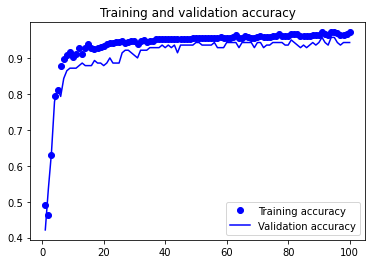

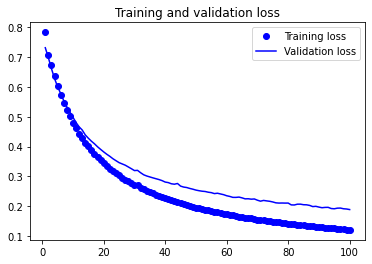

In [42]:
# Plot results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Classifier2: Global Average Pooling Model in Action

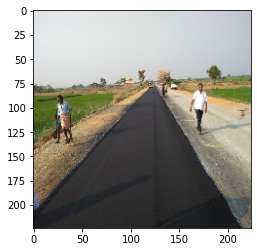

Plain


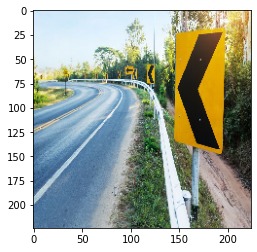

Plain


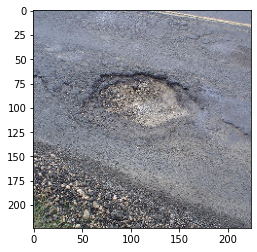

Pothole


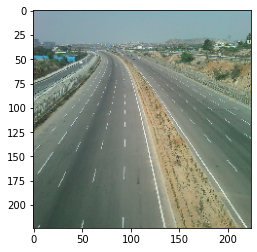

Plain


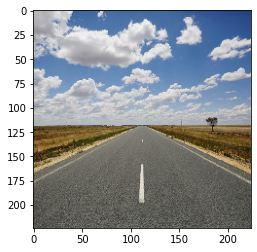

Plain


In [43]:
# Visualize predictions
visualize_predictions(model, 5)

### Classifier2: Global Average Pooling Model Performance Metrics

In [44]:
# Define function to visualize predictions
def test_output(classifier):
    result = []
    for f in test_features:
      try:
          prediction = classifier.predict(f)
      except:
          prediction = classifier.predict(f.reshape(1, 7, 7, 512))
      if(prediction < 0.5):
        result.append(0)
      else:
        result.append(1)
        
    return result
o = test_output(model)


Confusion Matrix: 
[[64  6]
 [ 5 65]]
Accuracy:  0.9214285714285714
Specificity:  0.9142857142857143
Precision/Positive Predictive Value:  0.9154929577464789
Negative Predictive Value:  0.927536231884058
Recall/Sensitivity:  0.9285714285714286
False Positive Rate:  0.5454545454545454
False Negative Rate:  0.07142857142857142
Positive Likelihood Ratio:  1.7023809523809526
Negative Likelihod Ratio:  0.078125
Diagnostic Odds Ratio:  21.79047619047619
False Omission Rate:  0.07246376811594203
F1 Score:  0.921985815602837
Area under ROC curve:  0.9214285714285715


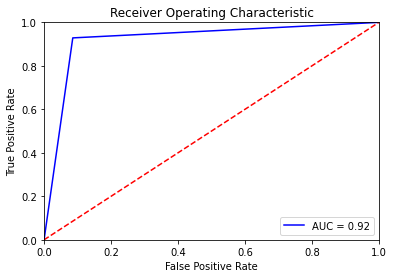

In [45]:
from sklearn.metrics import *
matrix = confusion_matrix(test_labels, o)
print("Confusion Matrix: ")
print(matrix)
[[tn, fp], [fn, tp]] = matrix

acc_score = accuracy_score(test_labels, o)
precision = precision_score(test_labels, o)
recall = tpr = recall_score(test_labels, o)
f1 = f1_score(test_labels, o)
roc_score = roc_auc_score(test_labels, o)
spc = tnr = tn/(tn + fp)
fpr = fp/(fp + fn)
fnr = fn/(fn+tp)
plr = tpr/fpr
nlr = fnr/tnr
dor = plr/nlr
npv = tn/(fn+tn)
fr = fn/(fn+tn)

print("Accuracy: ", acc_score)
print("Specificity: ", spc)
print("Precision/Positive Predictive Value: ", precision)
print("Negative Predictive Value: ", npv)
print("Recall/Sensitivity: ", recall)
print("False Positive Rate: ", fpr)
print("False Negative Rate: ", fnr)
print("Positive Likelihood Ratio: ", plr)
print("Negative Likelihod Ratio: ", nlr)
print("Diagnostic Odds Ratio: ", dor)
print("False Omission Rate: ", fr)
print("F1 Score: ", f1)
print("Area under ROC curve: ", roc_score)


fpr, tpr, threshold = roc_curve(test_labels, o)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()